Apologize for the messy notebook - still trying to mess around with this stuff.

## Prelim Prep/Imports

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [26]:
df = pd.read_excel("SupplyChain_TimeSeriesData.xlsx")

In [27]:
# Using the Pandas bdate_range function, we calculate number of days taken to complete order (excluding weekends)
df['scheduled_duration_nowkend'] = df.apply(lambda row: pd.bdate_range( row['Schedule Start Date'], row['Schedule Finish Date']).shape[0] \
                                            if not pd.isna(row['Schedule Start Date']) and not pd.isna(row['Schedule Finish Date']) else np.nan, axis=1 )
df['actual_duration_nowkend'] = df.apply(lambda row: pd.bdate_range( row['Confirmation Start Date'], row['Usage Decision Date']).shape[0] \
                                         if not pd.isna(row['Confirmation Start Date']) and not pd.isna(row['Usage Decision Date']) else np.nan, axis=1 )

# Drop null values
df = df.dropna(subset=['Confirmation Start Date', 'Usage Decision Date'])

# Drop dates before 2016
orders = df[df['Confirmation Start Date'] < pd.Timestamp(2017,1,1)]['Order'].unique()
df = df[~df['Order'].isin(orders)]

df.head()

,Order,Material,Batch,Group,MaterialCategory,Total order quantity,Unit,Quantity of goods received,Schedule Start Date,Schedule Finish Date,Confirmation Start Date,First Goods Movement Date,Goods Receipt Date,Usage Decision Date,dur,scheduled_duration_nowkend,actual_duration_nowkend
478,101863,100001706,B174,138,13,14.0,PC,14.0,2016-11-21,2016-11-29,2017-02-22,2016-11-18,2016-11-18,2016-11-21,-68,7,0
549,101986,100001706,B203,138,13,14.0,PC,14.0,2016-11-23,2016-12-01,2017-02-22,2016-11-23,2016-11-23,2016-11-23,-66,7,0
705,101990,100001705,B216,138,13,42.0,PC,42.0,2016-11-30,2016-12-06,2017-02-22,2016-11-30,2016-11-30,2016-12-01,-60,5,0
765,102129,100002226,B233,138,1,30000.0,ML,30000.0,2016-11-29,2016-12-02,2017-02-22,2016-11-29,2016-11-29,2016-12-05,-58,4,0
766,101992,100001705,B224,138,13,102.0,PC,102.0,2016-12-05,2016-12-09,2017-02-22,2016-12-05,2016-12-05,2016-12-05,-58,5,0


In [28]:
#Change the units to ML
df.loc[df["Unit"] == "µL", "Total order quantity"] = df["Total order quantity"]/1000
df.loc[df["Unit"] == "µL", "Unit"] = "ML"

df.loc[df["Unit"] == "L", "Total order quantity"] = df["Total order quantity"] * 1000
df.loc[df["Unit"] == "L", "Unit"] = "ML"

display(df.shape)
display(df.head())

(31961, 17)

,Order,Material,Batch,Group,MaterialCategory,Total order quantity,Unit,Quantity of goods received,Schedule Start Date,Schedule Finish Date,Confirmation Start Date,First Goods Movement Date,Goods Receipt Date,Usage Decision Date,dur,scheduled_duration_nowkend,actual_duration_nowkend
478,101863,100001706,B174,138,13,14.0,PC,14.0,2016-11-21,2016-11-29,2017-02-22,2016-11-18,2016-11-18,2016-11-21,-68,7,0
549,101986,100001706,B203,138,13,14.0,PC,14.0,2016-11-23,2016-12-01,2017-02-22,2016-11-23,2016-11-23,2016-11-23,-66,7,0
705,101990,100001705,B216,138,13,42.0,PC,42.0,2016-11-30,2016-12-06,2017-02-22,2016-11-30,2016-11-30,2016-12-01,-60,5,0
765,102129,100002226,B233,138,1,30000.0,ML,30000.0,2016-11-29,2016-12-02,2017-02-22,2016-11-29,2016-11-29,2016-12-05,-58,4,0
766,101992,100001705,B224,138,13,102.0,PC,102.0,2016-12-05,2016-12-09,2017-02-22,2016-12-05,2016-12-05,2016-12-05,-58,5,0


In [29]:
# Get rid of negative durations
df = df[df['dur']>0]
# Set indices
df.set_index("Confirmation Start Date", inplace = True)
df["month"] = df.index.to_period("M")

## Grouping
Groups based on the assumption that the hierarchy is category -> group -> material from least precise to most precise. Starts by determining all possible groupings of material that have enough data to make a forecast, then moves to group, and finally to category. This information is stored in dictionaries mat_trend, group_trend, cat_trend.

In [31]:
import copy
types = ['Material', 'Group', 'MaterialCategory']
dics = {'mat_trend' : {}, 'group_trend' : {}, 'cat_trend' : {}}
thresholds = [75,75,50]


for (typ, dic, thresh) in zip(types, dics, thresholds):
    # Group 
    gr = df.groupby(typ)
    groups = dict(list(gr))
    # Checks if group has enough data
    for x in groups:
        single = groups[x]
        if len(single) > thresh:
            dics[dic][x] = single

# Transfer back over for ease later            
mat_trend = dics['mat_trend']
group_trend = dics['group_trend']
cat_trend = dics['cat_trend']

# Lists of keys
mats = list(mat_trend.keys())
groups = list(group_trend.keys())
cats = list(cat_trend.keys())

# Note to self: 48, 42, 11
print("Material groups that have enough data: %d" % len(mat_trend))
print("Group groups that have enough data: %d" % len(group_trend))
print("Category groups that have enough data: %d" % len(cat_trend))

Material groups that have enough data: 48
Group groups that have enough data: 41
Category groups that have enough data: 11


## Get Rid of Outliers

In [144]:
def remove_outliers(group, time, method):
    
    updated_group = pd.DataFrame() 
    if(time == 'month'):
        dates = pd.unique(group["month"])
        for month in dates:
            df_quarter = group.loc[group["month"] == month]
            if method == 'zscore':
                df_quarter['zscore'] = np.abs(stats.zscore(df_quarter['actual_duration_nowkend']))
                temp = df_quarter.loc[df_quarter['zscore'] < 3]
            elif method == 'iqr':
                q1 = df_quarter.quantile(0.25)['actual_duration_nowkend']
                q2 = df_quarter.quantile(0.50)['actual_duration_nowkend']
                q3 = df_quarter.quantile(0.75)['actual_duration_nowkend']

                IQR = q3 - q1
                lower = q1 - 1.5*IQR
                upper = q3 + 1.5*IQR

                # Removes outliers
                temp = df_quarter[(df_quarter['actual_duration_nowkend'] < upper) & (df_quarter['actual_duration_nowkend'] > lower)]
            updated_group = updated_group.append(temp)   
        updated_group = updated_group.sort_values(by='Usage Decision Date')
        return updated_group
    elif(time == 'total'):
        if method == 'zscore':
            group['zscore'] = np.abs(stats.zscore(group['actual_duration_nowkend']))
            group = group[group['zscore'] < 3]
            group.sort_values(by='Usage Decision Date')
            return group

    

In [145]:
lists = [mats, groups, cats]
dics = [mat_trend, group_trend, cat_trend]
types = ['Material', 'Group', 'MaterialCategory']

# new dictionaries to copy over data without outliers
mat_trend_trim = {}
group_trend_trim = {}
cat_trend_trim = {}
new_dics = [mat_trend_trim, group_trend_trim, cat_trend_trim]


# Track amount of datapoints deleted
deltas = []
# method for outlier detection - choose zscore / iqr 
method = 'iqr'
for (typ, lis, olddic, newdic) in zip(types, lists, dics, new_dics):
    delta = []
    for x in lis:
        group = olddic[x]
        start = len(group)
        # Get rid of outliers
        group = remove_outliers(group, 'total', 'zscore')
        group = remove_outliers(group, 'month', 'iqr')
        # calculate datapoints lost
        end = len(group)
        delta.append([x, start, end, start-end, (100*(start-end)/start)])
        # Combine datapoints in same month for consistent frequency
        group_resample = group.resample("M").mean()
        group_resample["actual_duration_nowkend"] = group_resample["actual_duration_nowkend"].fillna(method = "ffill")
        newdic[x] = group_resample
    #append to overall list    
    deltas.append(pd.DataFrame(delta, columns=[typ, 'Start', 'End', 'Delta', 'Percentlost']))
    

In [146]:
# Shows data loss with outlier method 
# 0 = Materials, 1 = Group, 2 = MaterialCategory
print('Materials outlier mean data percent lost: %0.2f' % deltas[0]['Percentlost'].mean())
print('Groups outlier mean data percent lost: %0.2f' % deltas[1]['Percentlost'].mean())
print('MaterialCategory outlier mean data percent lost: %0.2f' % deltas[2]['Percentlost'].mean())

#Results: 

# For IQR: 
# Materials outlier mean data percent lost: 12.67
# Groups outlier mean data percent lost: 10.56
# MaterialCategory outlier mean data percent lost: 9.13

#For z-score of 3:
# Materials outlier mean data percent lost: 8.03
# Groups outlier mean data percent lost: 5.00
# MaterialCategory outlier mean data percent lost: 3.31

Materials outlier mean data percent lost: 15.92
Groups outlier mean data percent lost: 12.83
MaterialCategory outlier mean data percent lost: 11.36


In [ ]:
# See data loss for different materials
# 0 = Materials, 1 = Group, 2 = MaterialCategory
deltas[0].sort_values(by = 'End')

## ARIMA MODELING

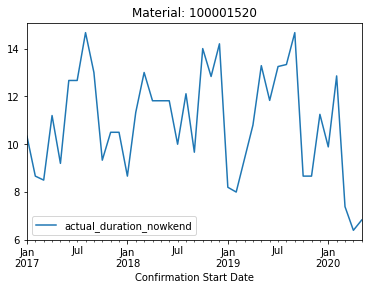

In [148]:
#Taking random group to test ARIMA model on
# 100001520
name = 100001520
sub = mat_trend_trim[name]
sub.plot(y = 'actual_duration_nowkend', title = "Material: %d" % name)

In [154]:
ts = pd.Series(sub['actual_duration_nowkend'].values, index = sub.index)

In [155]:
# Array of external variables
exog_df = pd.DataFrame(sub['Total order quantity'])
exog_df = exog_df.fillna(method = "ffill")

# Convert to values for arima model
exog_arr = exog_df.values

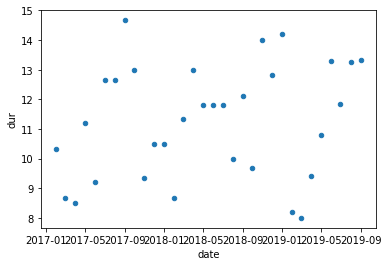

In [156]:
# Splitting data into test/train
ratio = 0.8
length = ts.shape[0]
pivot = int(ratio * length)
endpivot = length - pivot

ts_train = ts[:pivot]
ts_test = ts[pivot:]

exog_train = exog_arr[:pivot]
exog_test = exog_arr[pivot:]

dates_train = ts[:pivot]
dates_test = ts[pivot:]

# Just visualizing data
dfmod = ts_train.to_frame()
dfmod.reset_index(inplace=True)
dfmod.columns = ['date','dur']
dfmod.plot(kind = 'scatter', x='date',y='dur')
plt.show() 

In [158]:
# Fitting
arima = pm.auto_arima(ts_train, exog_train,start_p=1, start_q=1, max_p=5, max_q=5, m=12,start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings = True, stepwise=True)
arima2 = pm.auto_arima(ts_train, exog_train, d=1, error_action='ignore', suppress_warnings = True)
arima3 = pm.auto_arima(ts_train, seasonal=True, error_action='ignore', suppress_warnings = True)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=105.084, BIC=110.751, Time=1.595 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=101.576, BIC=104.410, Time=0.040 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=102.830, BIC=107.553, Time=0.592 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=101.364, BIC=106.086, Time=0.778 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=99.874, BIC=101.763, Time=0.046 seconds
Fit ARIMA(0,1,0)x(1,1,0,12) [intercept=True]; AIC=102.996, BIC=106.774, Time=0.185 seconds
Fit ARIMA(0,1,0)x(0,1,1,12) [intercept=True]; AIC=102.996, BIC=106.774, Time=0.305 seconds
Fit ARIMA(0,1,0)x(1,1,1,12) [intercept=True]; AIC=104.996, BIC=109.719, Time=0.351 seconds
Fit ARIMA(1,1,0)x(0,1,0,12) [intercept=True]; AIC=102.909, BIC=106.686

In [159]:
display(arima.summary())
display(arima2.summary())
display(arima3.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   32
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -47.937
Date:                            Mon, 06 Jul 2020   AIC                             99.874
Time:                                    16:44:42   BIC                            101.763
Sample:                                         0   HQIC                           100.194
                                             - 32                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0234      0.068      0.345      0.730      -0.110       0.156
sigma2         9.0988      2.725      3.339      0.001       3.758      14.439
===================================================================================
Ljung-Box (Q):                       20.82   Jarque-Bera (JB):                 1.38
Prob(Q):                              0.29   Prob(JB):                         0.50
Heteroskedasticity (H):               0.65   Skew:                             0.66
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 -57.712
Date:                Mon, 06 Jul 2020   AIC                            131.424
Time:                        16:44:42   BIC                            142.896
Sample:                             0   HQIC                           135.164
                                 - 32                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0036      0.012     -0.292      0.770      -0.028       0.021
x1             0.0072      0.006      1.227      0.220      -0.004       0.019
ar.L1          0.6841      0.202      3.391      0.001       0.289       1.079
ar.L2          0.1236      0.158      0.780      0.436      -0.187       0.434
ar.L3         -0.5234      0.181     -2.895      0.004      -0.878      -0.169
ma.L1         -1.8363      1.635     -1.123      0.261      -5.041       1.369
ma.L2          0.8455      1.250      0.677      0.499      -1.604       3.295
sigma2         1.6118      3.161      0.510      0.610      -4.583       7.806
===================================================================================
Ljung-Box (Q):                       24.35   Jarque-Bera (JB):                 1.74
Prob(Q):                              0.76   Prob(JB):                         0.42
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.60   Kurtosis:                         1.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -63.855
Date:                Mon, 06 Jul 2020   AIC                            133.709
Time:                        16:44:42   BIC                            138.106
Sample:                             0   HQIC                           135.167
                                 - 32                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.5810      2.118      3.579      0.000       3.429      11.733
ar.L1          0.3283      0.184      1.780      0.075      -0.033       0.690
sigma2         3.1567      1.103      2.863      0.004       0.995       5.318
===================================================================================
Ljung-Box (Q):                       39.92   Jarque-Bera (JB):                 0.93
Prob(Q):                              0.13   Prob(JB):                         0.63
Heteroskedasticity (H):               1.39   Skew:                            -0.22
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [160]:
arima.fit(ts_train, exog_train)
arima2.fit(ts_train, exog_train)
arima3.fit(ts_train)

ARIMA(order=(1, 0, 0), suppress_warnings=True)

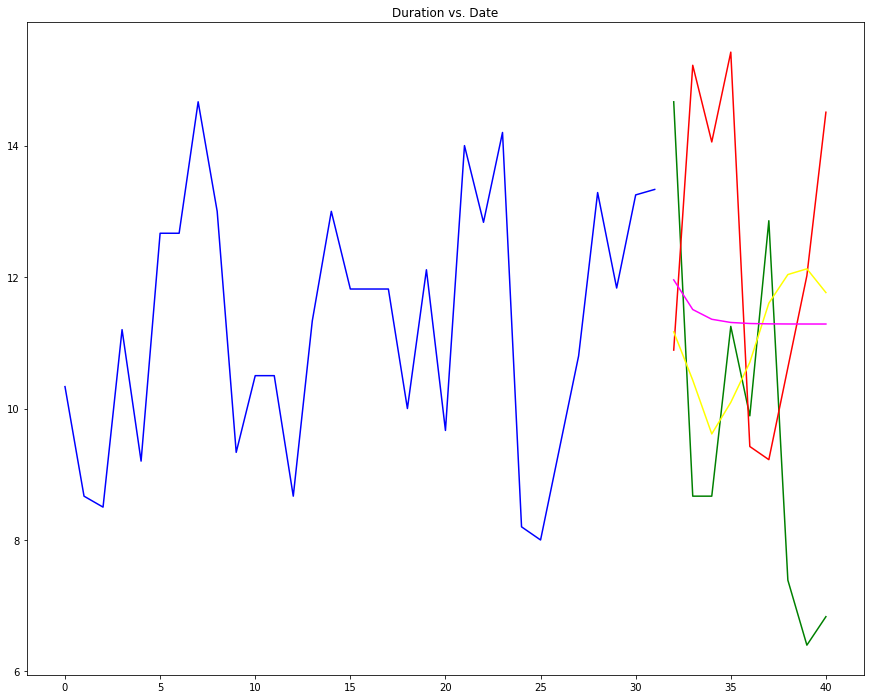

In [162]:
num_test = ts_test.shape[0]
# forecasts
forecasts = arima.predict(n_periods = num_test, exogenous = exog_test)  # predict 
forecasts2 = arima2.predict(n_periods = num_test, exogenous = exog_test)
forecasts3 = arima3.predict(n_periods = num_test)
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(length)
s = 2.0 ** 2
plt.plot(x[:pivot], ts_train, c='blue')
plt.plot(x[pivot:], ts_test, c = 'green')
plt.plot(x[pivot:], forecasts, c='red')
plt.plot(x[pivot:], forecasts2, c='yellow')
plt.plot(x[pivot:], forecasts3, c='magenta')
plt.gcf().set_size_inches(15, 12)
plt.title('Duration vs. Date')
plt.show()


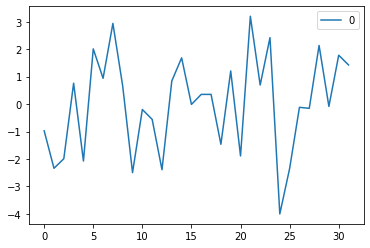

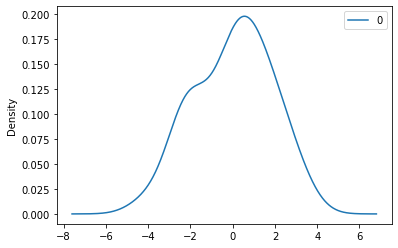

               0
count  32.000000
mean    0.009362
std     1.799970
min    -4.001546
25%    -1.571328
50%     0.170181
75%     1.262149
max     3.199643


In [135]:
residuals = pd.DataFrame(arima3.resid())
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [164]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(ts_test, forecasts)
error2 = mean_squared_error(ts_test, forecasts2)
error3 = mean_squared_error(ts_test, forecasts3)
print('Test MSE: %.3f' % error)
print('Test2 MSE: %.3f' % error2)
print('Test3 MSE: %.3f' % error3)

Test MSE: 24.232
Test2 MSE: 10.950
Test3 MSE: 9.552
